In [3]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import networkx as nx
import random

# Step 1

## Uploading the data

In [4]:
def get_data(dot_file_path):
    '''Returns the nodes, edges (both in pydot format), a list with all the nodes and another with all the edges, and also a dic with (edge):weigth
    '''
     #= 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {}
    if edges[0].get_attributes()!={}:
        name= str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()):float(edge.get_attributes()[name]) for edge in edges}

    return nodes,edges,node_list,edge_list,weights
#
# ans = get_data('Datasets/JazzNetwork.dot')
# print(ans[-1])
#nodes,edges,node_list,edge_list,weights = get_data('Datasets/LesMiserables.dot')
#print(('1','40') in edge_list)
# print(len(node_list)**3) #nodes
# print(len(edge_list))
# print(len(edge_list)*len(node_list)) #edges
# print()
# Nodes:  77 
#Edges:  254
#Total:  33982

## Tree Layout

### Counting the number of children/parents for each node

In [5]:
#COUNTING THE NUMBER OF CHILD NODES FOR EACH NODE
def f_childs(file_name_name):  
    '''Returns the count of child nodes [0] and a list of them [1] for all nodes
    ''' 
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_child_count = {node.get_name(): 0 for node in nodes}
    node_childs = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if source in node_child_count:
            node_child_count[source] += 1 
            node_childs[source].append(destination) #comment
    return node_child_count, node_childs

#Count
print(f_childs('Datasets/LesMiserables.dot')[1])
#print(sum(list(f_childs('Datasets/LesMiserables.dot')[0].values())))
#child_11,child_25,child_26 = f_childs('Datasets/LesMiserables.dot')[1]['11'],f_childs('Datasets/LesMiserables.dot')[1]['25'],f_childs('Datasets/LesMiserables.dot')[1]['26']
#print('CHILD')
#print('11: ',child_11)
#print('25: ',child_25)
#print('26": ',child_26)

#List      
#print(f_childs('Datasets/LesMiserables.dot')[1])

def f_parents(file_name_name):
    '''Returns the count of parent nodes [0] and a list of them [1] for all nodes
    '''
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_parent_count = {node.get_name(): 0 for node in nodes}
    node_parents = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if destination in node_parent_count:
            node_parent_count[destination] += 1 
            node_parents[destination].append(source)
    return node_parent_count, node_parents

#Count
#print(f_parents('Datasets/LesMiserables.dot')[0]['11'])
#parent_27 = f_parents('Datasets/LesMiserables.dot')[1]['27']
#print("PARENT")
#print('27: ', parent_27)
#List      
#print(f_parents('Datasets/LesMiserables.dot')[1])

def f_edges(file_name):
    '''Returns the count of edges [0] and a list of them [1] for all nodes
    '''
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges

#print(f_edges('Datasets/LesMiserables.dot')[1])
#print(f_parents('Datasets/LesMiserables.dot')[1])

#edges = f_edges('Datasets/LesMiserables.dot')
#parents = f_parents('Datasets/LesMiserables.dot')

#print(edges == parents)
#print(edges[0])

{'1': ['2'], '2': ['3', '4', '5', '6', '7', '8', '9', '10', '11'], '3': ['4', '11'], '4': ['11'], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': ['12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '44', '45', '49', '50', '52', '56', '59', '65', '69', '70', '71', '72', '73'], '12': [], '13': ['24'], '14': [], '15': [], '16': [], '24': ['17', '18', '19', '20', '21', '22', '23', '25', '26', '28', '30', '31', '32'], '25': ['26', '27', '28', '42', '43', '51', '69', '70', '71'], '26': ['27', '28', '40', '41', '42', '43', '49', '56', '69', '70', '71', '72', '76'], '27': ['18', '28', '44', '50', '52', '55', '56', '73'], '28': ['29', '30', '32', '34', '44', '49', '59', '69', '70', '71', '72', '73'], '29': ['45', '46'], '30': ['35', '36', '37', '38', '39'], '32': ['31'], '33': [], '34': [], '35': ['36', '37', '38', '39'], '36': ['37', '38', '39'], '37': ['38', '39'], '38': ['39'], '39': [], '44': [], '45': [], '49

### Organizing the nodes throughout the graph, getting their coordinates for the tree layout

In [6]:
def tree_layout(file):
    '''First layout we implemeted
    '''
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    #lonely_nodes_y = -4
    
    for edge in edges:
        n+=1
        l_m = []
        m=0
        #print(edge)#.get_source())
    #    print(node_childs[str(edge.get_destination())])
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        step = 3#random.choice([2,3])

        #nnodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            #random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                m+=1
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
            l_m.append(m)
            total += m
        total+=n
        #elif len(node_childs[str(edge.get_source())]) == 0 and len(node_childs[str(edge.get_destination())]) == 0:
        #    node_positions[child]

        #elif len([done_node for done_node in done_nodes if done_node == edge.get_destination()])==1:
        #    child_x += 1               
        
    return node_positions,n,l_m,total

#pos,n,m,total = tree_layout('Datasets/LesMiserables.dot')
#print("Edges: ",n, '\n',"Nodes: ",m, '\n',"Total: ",total,)
#f_childs(nodes,edges)[1]['17']

### Improved version of the Tree layout

Get the nodes that have the same parent and are directly connected to each other

In [7]:
def common_parents(file_name):
    '''Returns a dic with all the nodes as keys and as values the number of common parents
    '''
    nodes,edges,node_list,edge_list,weights = get_data(file_name)
    ans = {node:[] for node in node_list}
    count = {node:0 for node in node_list}
    for edge1 in edges:
        for edge2 in edges:
            if edge1.get_source() == edge2.get_source() and edge1.get_destination() != edge2.get_destination() and (str(edge1.get_destination()),str(edge2.get_destination())) in edge_list:# and str(edge1.get_destination()) not in ans:
                #ans.append((str(edge1.get_destination()),str(edge2.get_destination())))
                #ans[edge1.get_source()] = []
                ans[edge1.get_source()].append((str(edge1.get_destination()),str(edge2.get_destination())))
   
    for node,edges in ans.items():
        for edge in edges:
            #print(edge)
            count[edge[1]] += 1
    return count

#common_parents('Datasets/LesMiserables.dot')

In [8]:
def tree_layout_improv(file):
    '''returns the coordinates for each node with the improvment of not having connected siblings in the same vertical line
    '''
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    
    for edge in edges:
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        
        #weights
        position = str(str(edge.get_attributes())).rfind(':')
        if int(position) != -1:
            w = int(str(edge.get_attributes())[position+3:-2])
            if w != 1:
                w = w/10

        #nodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            step = 3#random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
            print()
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                step = 3#random.choice([2,3])
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
        #elif len([done_node for done_node in done_nodes if done_node == edge.get_destination()])==1:
        #    child_x += 1
                
    #correcting the child_x in cases where sibling nodes are connected to each other
    for node,count in [(node,count) for node,count in common_parents(file).items() if count != 0]:
        node_positions[node] = (node_positions[node][0]+count/3,node_positions[node][1])
    
    return node_positions

#tree_layout_improv('Datasets/LesMiserables.dot')

### Time complexity of the improved version

In [9]:
def time_complexity(file,layout,tree='BFS',ite=10):
    '''Returnt the average (ite) time complexity of a specific layout'''
    ans = []
    for i in range(ite):
        if layout == 'tree_layout':
            start_time = time.time() 
            result = tree_layout(file)
            end_time = time.time() 
        
        if layout == 'tree_layout_improv':
            start_time = time.time() 
            result = tree_layout_improv(file)
            end_time = time.time() 
        if layout == 'radial':
            start_time = time.time() 
            result = radial(file,tree)
            end_time = time.time() 
         # Record the end time
        elapsed_time = end_time - start_time  # Calculate the elapsed time
        ans.append(elapsed_time)
    print('In average, the layout',layout, 'takes', round(sum(ans)/len(ans), 2),'seconds to implement on the', file,'dataset.') 

#time_complexity(file,layout)

### Bonus Task

In [10]:
#HOW TO CREATE THE DEFAULT LAYOUT
def bonus_task(file,layout):
    with open(file, 'r') as dot_file:
        dot_data = dot_file.read()

    # Create a graph object from the .dot data
    graph = pydot.graph_from_dot_data(dot_data)

    # Set the layout algorithm to "dot" (or any other supported layout type)
    graph[0].set_graph_defaults(layout=layout)
    graph[0].set_graph_defaults(layout=layout,)
    # Render the graph with Graphviz
    output_file_path = layout+'.png'
    graph[0].write_png(output_file_path)

# Step 2

### Constructing a BFS tree

In [11]:
def layered_ish(file):
    '''Returns the node positions {node:(x,y) and also the final tree (edges and stuff)
    '''
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    #edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes = set()
    #node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    min_y = 0

    for node in nodes:
        done_nodes.add(str(node.get_name()))
        childs = node_childs[str(node.get_name())]
        parent_x = node_positions[str(node.get_name())][0]
        parent_y = node_positions[str(node.get_name())][1]
        step = 3

        if len(node_childs[str(node.get_name())]) == 1 and str(node_childs[str(node.get_name())][0]) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            child_x = parent_x + step
            child_y = parent_y
            node_positions[str(node_childs[str(node.get_name())][0])] = (child_x, child_y)
            done_nodes.add(str(node_childs[str(node.get_name())][0]))
            
        elif len(node_childs[str(node.get_name())]) >1:# and node_childs[str(node.get_name())] not in done_nodes:
            new_childs = len([child for child in node_childs[str(node.get_name())] if child not in done_nodes])
            max_y = (new_childs-1)*3
            
            done_childs = []
            for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
                done_childs.append(child)
                child_x = parent_x + step
                child_y = parent_y + max_y
                
                node_positions[child] = (child_x, child_y)
                done_nodes.add(str(child))
                max_y -= 6

            if len(done_childs)>0:
                min_y = node_positions[done_childs[-1]][1]
    return node_positions

#write_ordered_dic('Datasets/LesMiserables.dot')
# tree = layered_ish('Datasets/LesMiserables.dot')
# tree

In [12]:
def BFS_tree(file):
    '''Returns the BFS tree (edges and stuff) {parent:[childs]}
    '''
    graph = get_data(file)
    nodes = graph[0]
    done_nodes = set()
    node_childs = f_childs(file)[1]
    tree = {node.get_name(): [] for node in nodes}
    
    for node in nodes:
        done_nodes.add(str(node.get_name()))
        done_childs = []
        for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
            done_childs.append(child)
            done_nodes.add(str(child))
            tree[node.get_name()].append(str(child))    
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return final_tree

#BFS_tree('ordered_LesMiserables.dot')
#BFS_tree('Datasets/LesMiserables.dot')


### Constructing the DFS tree

In [13]:
import networkx as nx
def tree_layout_DFS(file):
    #returns the coordinates for each node 
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]

    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    visited_nodes = []
    tree = {node.get_name(): [] for node in nodes}
    return dfs(node_positions, 1, node_childs=node_childs, visited_nodes=visited_nodes, edges=edges, tree=tree)



def dfs(node_positions, node, node_childs, visited_nodes, edges, tree, x=0, y=0):
    visited_nodes.append(node)
    parent_x, parent_y = x, y
    
    step_x = 1  # Horizontal step size
    step_y = 2  # Vertical step size

    nchilds = len(node_childs[str(node)])
    if nchilds == 0:
        return node_positions

    child_y = parent_y - step_y
    total_width = step_x * (nchilds - 1)
    start_x = parent_x - total_width / 2
    
    for i, child in enumerate(node_childs[str(node)]):
        if child not in visited_nodes:
            child_x = start_x + i * step_x
            node_positions[str(child)] = (child_x, child_y)

            tree[str(node)].append(child)
            dfs(node_positions, child, node_childs, visited_nodes, edges, tree, child_x, child_y)
    
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return node_positions, final_tree
#print(tree_layout_DFS('Datasets/LesMiserables.dot')[0])
#show_graph_with_invalid_edges('Datasets/LesMiserables.dot','layered_ish',tree = 'DFS')
#show_graph('ordered_LesMiserables.dot','radial',tree = 'DFS')

#show_graph('example.dot','radial',tree = 'DFS')
show_graph("Datasets/LesMiserables.dot", "layered_ish", tree="BFS")


NameError: name 'show_graph' is not defined

In [ ]:
#Non tree edges
#PLOT Graph with non-tree edges
def show_graph_with_invalid_edges(file,layout,tree='BFS', dims=(18,18)):
    edge_list,weigths = get_data(file)[3],get_data(file)[4]
    all_edges = get_data(file)[1]
    valid_nodes =  []
    if layout == 'tree_layout':
        node_positions = tree_layout(file)
        edges = get_data(file)[1]
    if layout == 'tree_layout_improv':
        node_positions = tree_layout_improv(file)
        edges = get_data(file)[1]

    if layout == 'layered_ish':
        node_positions = layered_ish(file)



    if tree == 'BFS' and layout in ['layered_ish','radial']:
        edges_ish = BFS_tree(file)
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='BFS')


    if tree == 'DFS' and layout in ['layered_ish','radial']:
        tree_org = tree_layout_DFS(file)
        edges_ish = tree_org[1]
        node_positions = tree_org[0]
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='DFS')

    plt.figure(figsize=(dims[0], dims[1]))
    w = 1
    for edge in edges:
        if layout not in ['layered_ish','radial']:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
        else:
            start_node = edge[0]
            end_node = edge[1]
            new_edge = (start_node,end_node)
            if new_edge not in edge_list:
                new_edge = (end_node,start_node)
            if weigths !={}:
                w = weigths[new_edge]
                if w != 1:
                    w=w/10

        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]
        valid_nodes.append((start_node, end_node))
        print(f"valid edge: {(start_node, end_node)}")
        print(f"adding edge between node {start_node} to node {end_node} ")
        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=2,zorder = 1)
        

    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')


    #add the invalid nodes
    for e in all_edges:
        if ((str(e.get_source()), str(e.get_destination())) or (str(e.get_destination()), str(e.get_source()))) not in valid_nodes:
            print(f"Invalid edge: {e.get_source()}, {e.get_destination()}")
            start_node = e.get_source()
            end_node = e.get_destination()

            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=0.5,zorder = 1, color="red")

    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.savefig('Plots/'+tree+'_'+layout+'_plot.png')
    plt.show()



{'0': (0, 0), '1': (3, 3), '2': (6, 6), '3': (9, 9), '4': (3, -3), '5': (6, 0), '6': (9, 3), '7': (12, 9), '8': (6, -3), '9': (9, 0)}


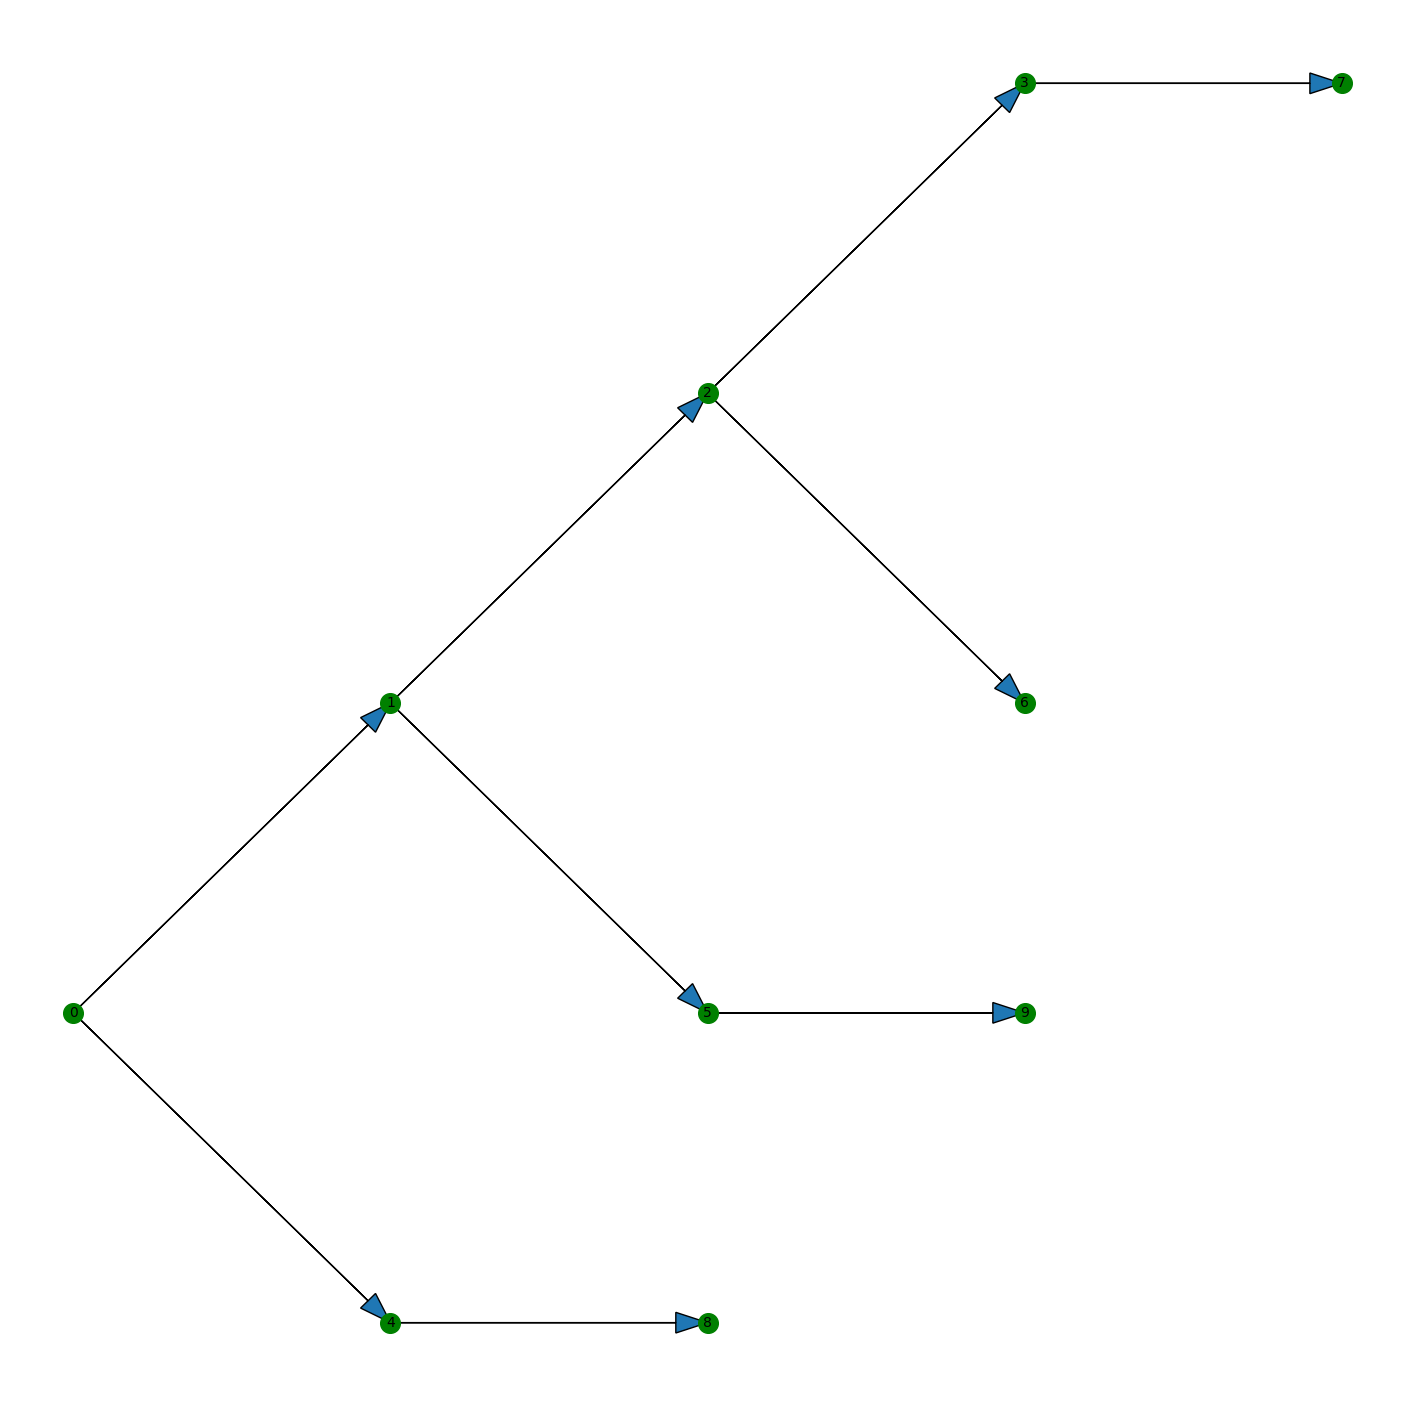

In [ ]:
#HOW TO PLOT A GENERAL GRAPH
def show_graph(file,layout,tree='BFS', dims=(18,18)):
    #nodes,edges = get_data(file)[0],get_data(file)[1]
    edge_list,weigths = get_data(file)[3],get_data(file)[4]
    if layout == 'tree_layout':
        node_positions = tree_layout(file)
        edges = get_data(file)[1]
    if layout == 'tree_layout_improv':
        node_positions = tree_layout_improv(file)
        edges = get_data(file)[1]
    if layout == 'layered_ish':
        node_positions = layered_ish(file)
        print(node_positions)
    
    if tree == 'BFS' and layout in ['layered_ish','radial']:
        edges_ish = BFS_tree(file)
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='BFS')
    
    # if tree == 'DFS' and layout in ['layered_ish','radial']:
    #     edges_ish = DFS_tree(file)[1]
    #     #print(edges_ish)
    #     edges = []
    #     for source,l_dest in edges_ish.items():
    #         for dest in l_dest:
    #             edges.append((source,dest))
    if tree == 'DFS' and layout in ['layered_ish','radial']:
        tree_org = tree_layout_DFS(file)
        edges_ish = tree_org[1]
        #node_positions = tree_org[0]
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='DFS')

    plt.figure(figsize=(dims[0], dims[1]))
    w = 1
    for edge in edges:
        if layout not in ['layered_ish','radial']:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
        else:
            start_node = edge[0]
            end_node = edge[1]
            new_edge = (start_node,end_node)
            if new_edge not in edge_list:
                new_edge = (end_node,start_node)
            if weigths !={}:
                w = weigths[new_edge]
                if w != 1:
                    w=w/10

        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]
        #plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
        plt.arrow(start_pos[0], start_pos[1],(end_pos[0] - start_pos[0]),(end_pos[1]-start_pos[1]), head_width=0.2, head_length=0.3, length_includes_head=True)

    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        
    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.savefig('Plots/'+tree+'_'+layout+'_plot.png')
    plt.show()
    
    
#show_graph('Datasets/LesMiserables.dot','tree_layout1',(18,18))
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'DFS')
show_graph("test_force.dot", layout="layered_ish", tree="BFS")

In [31]:
"""
Algorithm
Input: A directed graph G
Output: Layering of G, L1, ... , Lh
S := sources of G
i = 1;
while S 6= ∅ do
Li
:= S
i + +
G := G \ S
S := sources of G
"""
def get_set_of_vertices(node_list, edge_list):

    new = []
    for node in node_list:
        for edge in edge_list:
            if edge[1] == node:
                if node not in new:
                    new.append(node)

    valid_vertices = []
    for node in node_list:
        if node not in new:
            valid_vertices.append(node)

    return valid_vertices



def layer_assignment(file_name):
    graph = pydot.graph_from_dot_file(file_name)
    node_list = get_data(file_name)[2]
    edge_list = get_data(file_name)[3]
    set_vert = get_set_of_vertices(node_list, edge_list)
    iteration = 1
    layer = []
    list_layers = {}
    while len(set_vert) != 0:
        try:
            layer = set_vert
            list_layers[iteration] = layer
            iteration += 1
            for x in layer:
                print(x)
                node_list.remove(str(x))
        except:
            print("finished")
            break
        set_vert = get_set_of_vertices(node_list, edge_list)
        #print(list_layers)
    
    list_layers[iteration] = node_list
    print(list_layers)

layer_assignment("test_force.dot")
        

    


0
1
{1: ['0', '1'], 2: ['2', '3', '4', '5', '6', '7', '8', '9']}


# Radial Layout

### Sorting the nodes based on their degree and writing the new tree in a .dot file

In [ ]:
def f_edges(file_name):
    '''Returns the number and list of edges for each one of the nodes
    '''
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges

#final_edges = f_edges('Datasets/LesMiserables.dot')[1]

In [ ]:
def sort_nodes_degree(file):
    '''Returns a sorted dictionary containing the nodes, as keys, and a list of it's childs, as values, ordered based on the degree (> to <)
    '''
    return dict(sorted(f_edges(file)[1].items(), key=lambda item: len(item[1]), reverse=True))

def sort_nodes_degree_inverse(file):
    return dict(sorted(f_edges(file)[1].items(), key=lambda item: len(item[1])))

# dic = sort_nodes_degree('Datasets/LesMiserables.dot')
# dic

In [ ]:
def write_ordered_dic(file,new_file):
    '''writes a new .dot file but with the nodes ordered based of their degree
    '''
    dic = sort_nodes_degree_inverse(file)
    nodes_list = get_data(file)[2]
    edge_list = get_data(file)[3]
    weigths = get_data(file)[4]
    done_nodes = set()

    graph = pydot.Dot(graph_type='graph')
    
    #graph = nx.Graph()

    # for node_ish in nodes_list:
    #     node = pydot.Node(node_ish)
    #     graph.add_node(node)
    
    for node_ish,childs in dic.items():
        node = pydot.Node(node_ish)
        if node_ish not in done_nodes:
            graph.add_node(node)
            done_nodes.add(node_ish)
        for child_ish in childs:
            child = pydot.Node(child_ish)
            if child_ish not in done_nodes:
                graph.add_node(child)
                done_nodes.add(child_ish)
            #graph.add_node(child)
            edge_ish = (str(node_ish), str(child_ish) )
            if edge_ish not in edge_list:
                edge_ish = (str(child_ish), str(node_ish))
            w = int(weigths[edge_ish])
            edge = pydot.Edge(str(node_ish), str(child_ish), weight=w)
            graph.add_edge(edge)
            
    graph.write(new_file)

write_ordered_dic('Datasets/LesMiserables.dot','example.dot')

### Auxiliary functions for the radial layout

In [ ]:
def get_key(dictionary, value):
    '''Return the key of a specific value
    '''
    return next((key for key, val in dictionary.items() if value in val), None)

def count_descendants(tree, node_name, visited=None):
    if visited is None:
        visited = set()  # Initialize visited set

    # Base case: If node not in tree or already visited, return 0
    if node_name not in tree or node_name in visited:
        return 0
    
    visited.add(node_name)  # Mark node as visited

    descendants = 0
    if node_name in tree:
        children = tree[node_name]
        descendants += len(children)  # Add the direct children count
        for child in children:
            descendants += count_descendants(tree, child, visited)
    
    return descendants

def count_ancestors(tree, node_name):
    'returns the number (int) of ancestors of a node'
    ancestors = 0
    nodes = tree
    key = get_key(tree,node_name)
    #print('key',key)
    if key != None:
        parent = get_key(tree,node_name)
        ancestors += 1           
        ancestors += count_ancestors(tree, parent)
    return ancestors

def f_layers(file,layout='BFS'):
    '''Organizes the nodes based on the layer their own on a list of lists(index = layer)
    '''
    #if layout == 'BFS':
    #    tree = radial(file)[0]
    layers = []

    if layout == 'BFS':
        tree = BFS_tree(file)
        node_positions = layered_ish(file)
        for node, childs in tree.items():
            for child in childs:
                layer = int(node_positions[child][0]/3)
                while len(layers) <= layer:
                    layers.append([])
                layers[layer].append(child)
    if layout == 'DFS':
        tree = tree_layout_DFS(file)[1]
        node_positions = tree_layout_DFS(file)[0]
        for node, childs in tree.items():
            for child in childs:
                layer = -int(node_positions[child][1]/2)
                #print(layer)
                while len(layers) <= layer:
                    layers.append([])
                layers[layer].append(child)
    root = list(tree.keys())[0]
    layers[0].append(root)
    return [layer for layer in layers if layer != []]

#ans_layers =f_layers('ordered_LesMiserables.dot',layout='DFS')

In [ ]:
ans_layers

NameError: name 'ans_layers' is not defined

### Radial Implementation

In [ ]:
def radial(file,tree_type = 'BFS',ordesection = False):
    '''returns the nodes\' positions if we apply the radial layout implementation
    '''
    if ordesection != False:
        new_file = write_ordesection_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    if tree_type == 'DFS':
        tree = tree_layout_DFS(file)[1]
        layers = f_layers(file,layout='DFS')
    
    elif tree_type == 'BFS':
        tree = BFS_tree(file)
        layers = f_layers(file,layout='BFS')
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    #radius = 3
    root = list(tree.keys())[0]
    
    
    start_angle=0
    for subtree in tree:
        #root = subtree
        angle = 0
        for node in tree[subtree]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)
            #print(layer)
            radius = 3*layer

            parent_x = node_positions[get_key(tree,node)][0]
            parent_y = node_positions[get_key(tree,node)][1]
            #angle for the section for each node
            print(count_descendants(tree, subtree))
            section = 2*math.pi*(1+count_descendants(tree, subtree))/count_descendants(tree, root)
            #increment between sibling nodes
            increment = 2*math.pi*(count_descendants(tree, node)+1)/count_descendants(tree, root)
            
            if layer > 1 and tree[subtree].index(node)==0:
                #the starting angle must be the parent angle - half of section              
                start_angle = math.acos(parent_x/(3*(layer-1)))-section/2
                if parent_y <0:
                    #acos has domain [0,pi], so we need to fix it where x>pi
                    start_angle = -math.acos(parent_x/(3*(layer-1)))-section/2
                angle+= start_angle
            
            angle+= increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
   
    return node_positions


#write_ordesection_dic('Datasets/LesMiserables.dot')
#ans = radial('ordered_LesMiserables.dot',tree_type='DFS')
radial('ordered_LesMiserables.dot',tree_type='DFS')


77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
60
59
50
49
49
51
47
47
47
47
47
47
47
2
2
5
1
4
3
2
1
32
32
32
7
7
7
4
4
4
27
27
11
8
16
15
14
14
1
1
10
10
7
5
4
6
3
2
1
1
57
57
18
18
58
4
3
2
1
1


{'11': (-0.0, -0.0),
 '2': (-2.9975033980337487, -0.12236575818475647),
 '3': (-5.955111014946167, -0.7325659012449554),
 '4': (-8.93266652241925, -1.098848851867433),
 '12': (14.887777537365418, 1.8314147531123894),
 '13': (-13.237823651794812, 7.054078604891063),
 '14': (6.782578609240295, -13.378962120040402),
 '15': (7.850519755449201, -12.781601604231835),
 '16': (8.86621698793018, -12.099181638562927),
 '24': (-15.526897480817638, 9.105792366410451),
 '25': (1.2236575818475834, 29.975033980337486),
 '26': (1.3460233400323125, 32.972537378371236),
 '27': (6.543766901516729, 26.19502080049974),
 '28': (4.395395407469754, 35.730666089677),
 '29': (36.10694841081503, -14.740701355727348),
 '30': (38.991885199379055, -0.795542958264802),
 '32': (37.188309525078175, 11.748601391952143),
 '33': (9.822911009179316, -11.336243615313839),
 '34': (35.47564781882622, 16.201185507073575),
 '35': (41.92137067412142, -2.5687897545171947),
 '36': (44.7661139785652, -4.582034401672391),
 '37': (4

### Exercises

### Take a graph and compute a BFS tree of it


We decided to prune the layout algorithm we came up with on the first Step of this assignment, in order to get the layered layout, not only as the layout to use for all the tasks from Step 2, but also as way to get a representation of our BFS implementation. However, we ended up realizing that this layout is not the best one, given the amount of space wasted. That can be seen in Figure XXX. It's important to mention the fact that this algorithm is not finished, but if we indeed implemented it completely, the amount of wasted space would be even worse.

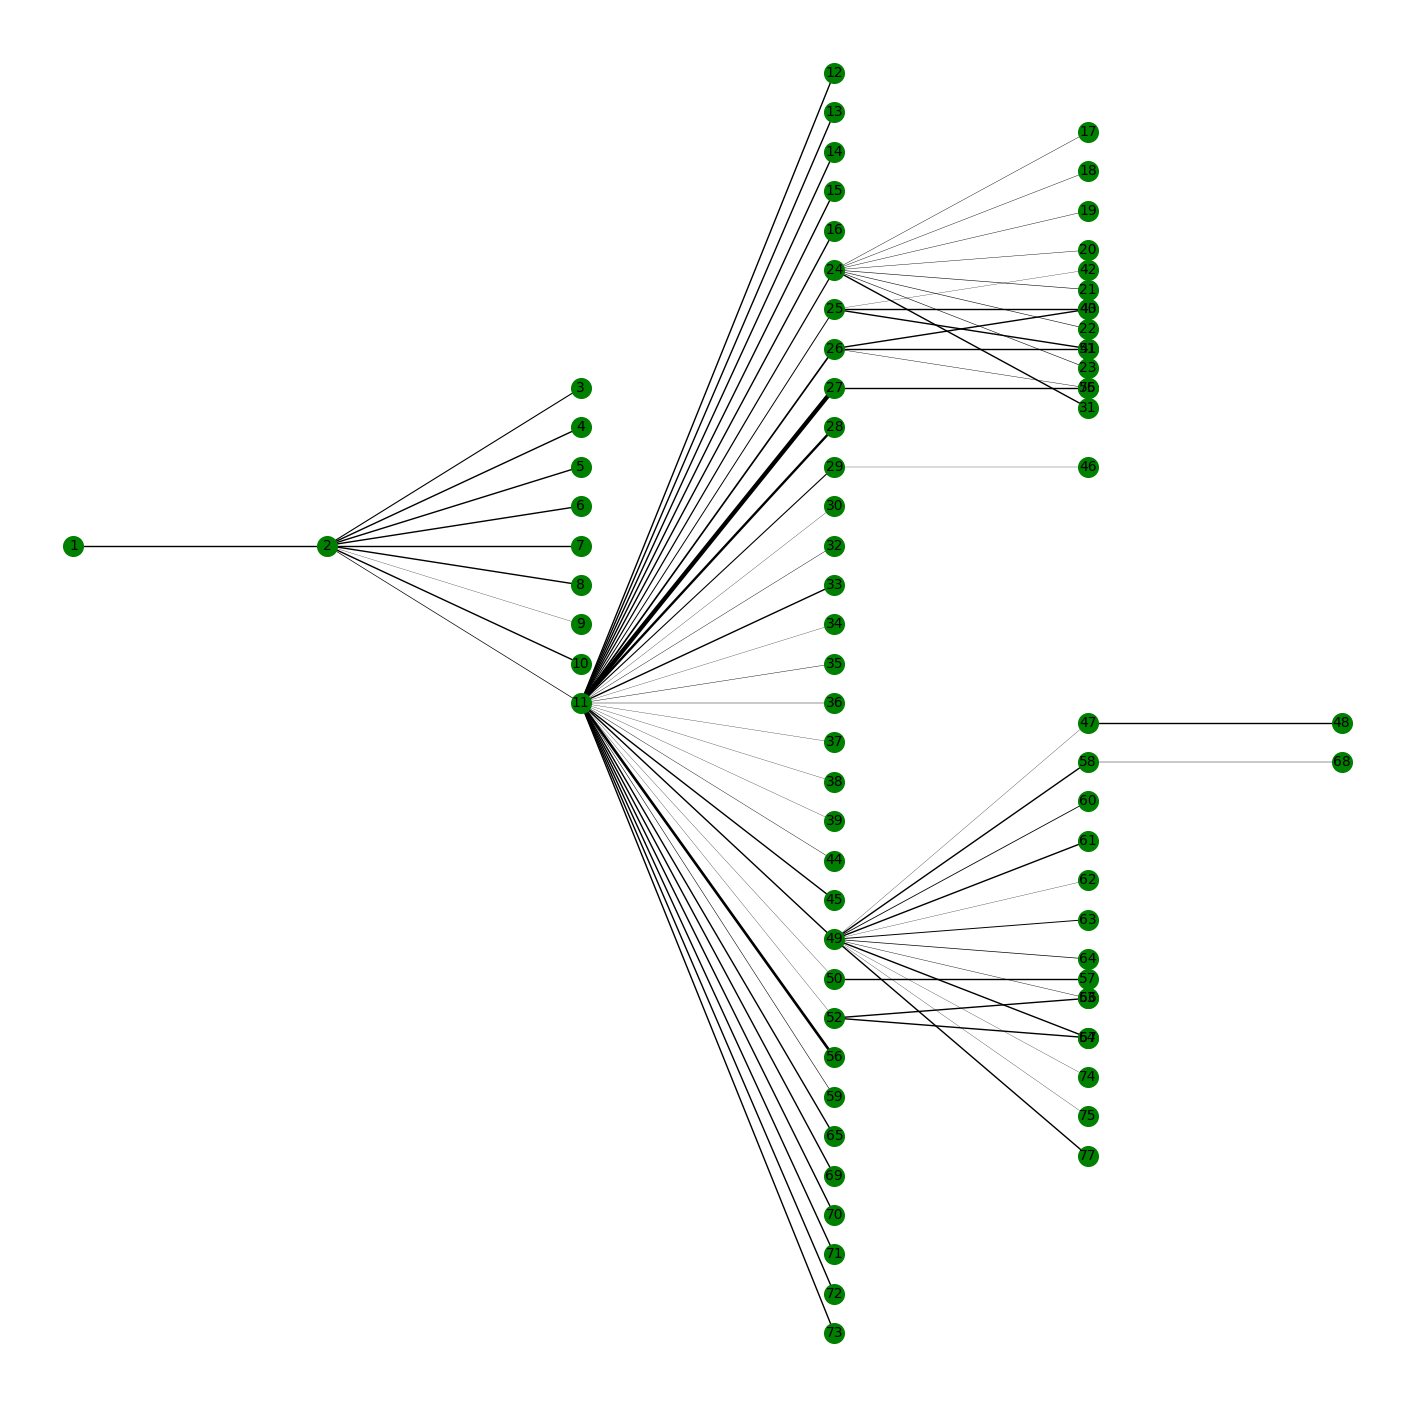

In [ ]:
#write_ordered_dic('Datasets/LesMiserables.dot','ordered_LesMiserables.dot')
show_graph('Datasets/LesMiserables.dot','layered_ish')

### Take a graph and compute a DFS tree of it

In order to get a DFS, we...

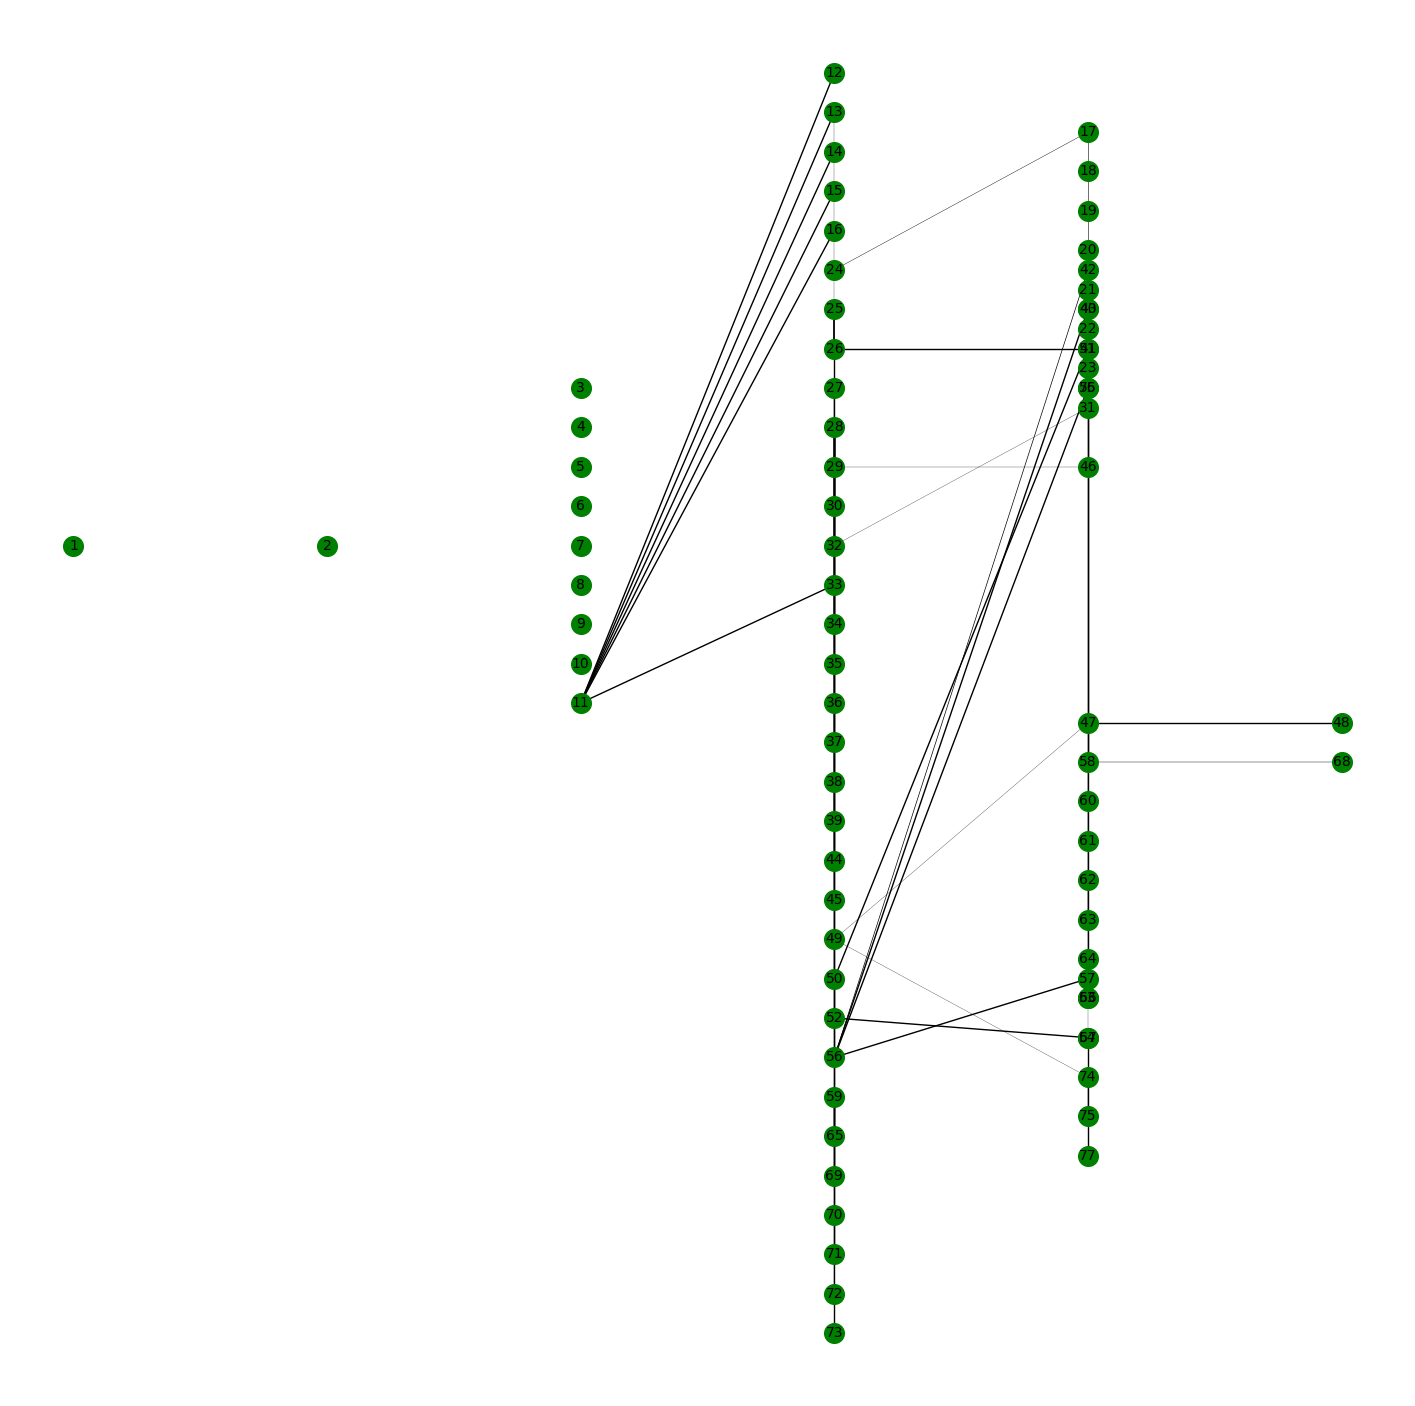

In [ ]:
show_graph('Datasets/LesMiserables.dot','layered_ish',tree = 'DFS')

### Implement radial layout

Time complexity

In [ ]:
time_complexity('Datasets/LesMiserables.dot','radial',10)
#time_complexity('ordered_LesMiserables.dot','radial',10)

UnboundLocalError: local variable 'tree' referenced before assignment

Implementation

We implemented the radial layout both on the Les Misérables network and to Jazz network, both using BFS

77
77
77
77
77
77
77
77
77
66
66
66
66
66
66
49
49
2
2
1
4
4
4
10
10
60
59
47
47
47
47
47
47
47
1
50
7
7
7
1
32
32
32
1
27
27
68
67
51
18
18
4
5
3
2
1
58
57
57
4
3
2
1
16
15
14
14
1
11
8
6
3
2
1
5
7
4
valid edge: ('1', '2')
adding edge between node 1 to node 2 
valid edge: ('2', '1')
adding edge between node 2 to node 1 
valid edge: ('2', '3')
adding edge between node 2 to node 3 
valid edge: ('2', '5')
adding edge between node 2 to node 5 
valid edge: ('2', '6')
adding edge between node 2 to node 6 
valid edge: ('2', '7')
adding edge between node 2 to node 7 
valid edge: ('2', '8')
adding edge between node 2 to node 8 
valid edge: ('2', '9')
adding edge between node 2 to node 9 
valid edge: ('2', '10')
adding edge between node 2 to node 10 
valid edge: ('11', '12')
adding edge between node 11 to node 12 
valid edge: ('11', '13')
adding edge between node 11 to node 13 
valid edge: ('11', '14')
adding edge between node 11 to node 14 
valid edge: ('11', '15')
adding edge between node 11 

C:\Users\magnu\AppData\Local\Temp\ipykernel_6124\690951335.py:84: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=0.5,zorder = 1, color="red")


Invalid edge: 49, 61
Invalid edge: 49, 62
Invalid edge: 49, 63
Invalid edge: 49, 64
Invalid edge: 49, 65
Invalid edge: 49, 66
Invalid edge: 49, 67
Invalid edge: 49, 69
Invalid edge: 49, 70
Invalid edge: 49, 72
Invalid edge: 49, 75
Invalid edge: 49, 76
Invalid edge: 49, 77
Invalid edge: 11, 2
Invalid edge: 11, 3
Invalid edge: 11, 4
Invalid edge: 11, 24
Invalid edge: 11, 25
Invalid edge: 11, 26
Invalid edge: 11, 27
Invalid edge: 11, 28
Invalid edge: 11, 29
Invalid edge: 11, 30
Invalid edge: 11, 32
Invalid edge: 11, 34
Invalid edge: 11, 35
Invalid edge: 11, 36
Invalid edge: 11, 37
Invalid edge: 11, 38
Invalid edge: 11, 39
Invalid edge: 11, 44
Invalid edge: 11, 45
Invalid edge: 11, 49
Invalid edge: 11, 50
Invalid edge: 11, 52
Invalid edge: 11, 56
Invalid edge: 11, 59
Invalid edge: 11, 65
Invalid edge: 11, 69
Invalid edge: 11, 70
Invalid edge: 11, 71
Invalid edge: 11, 72
Invalid edge: 11, 73


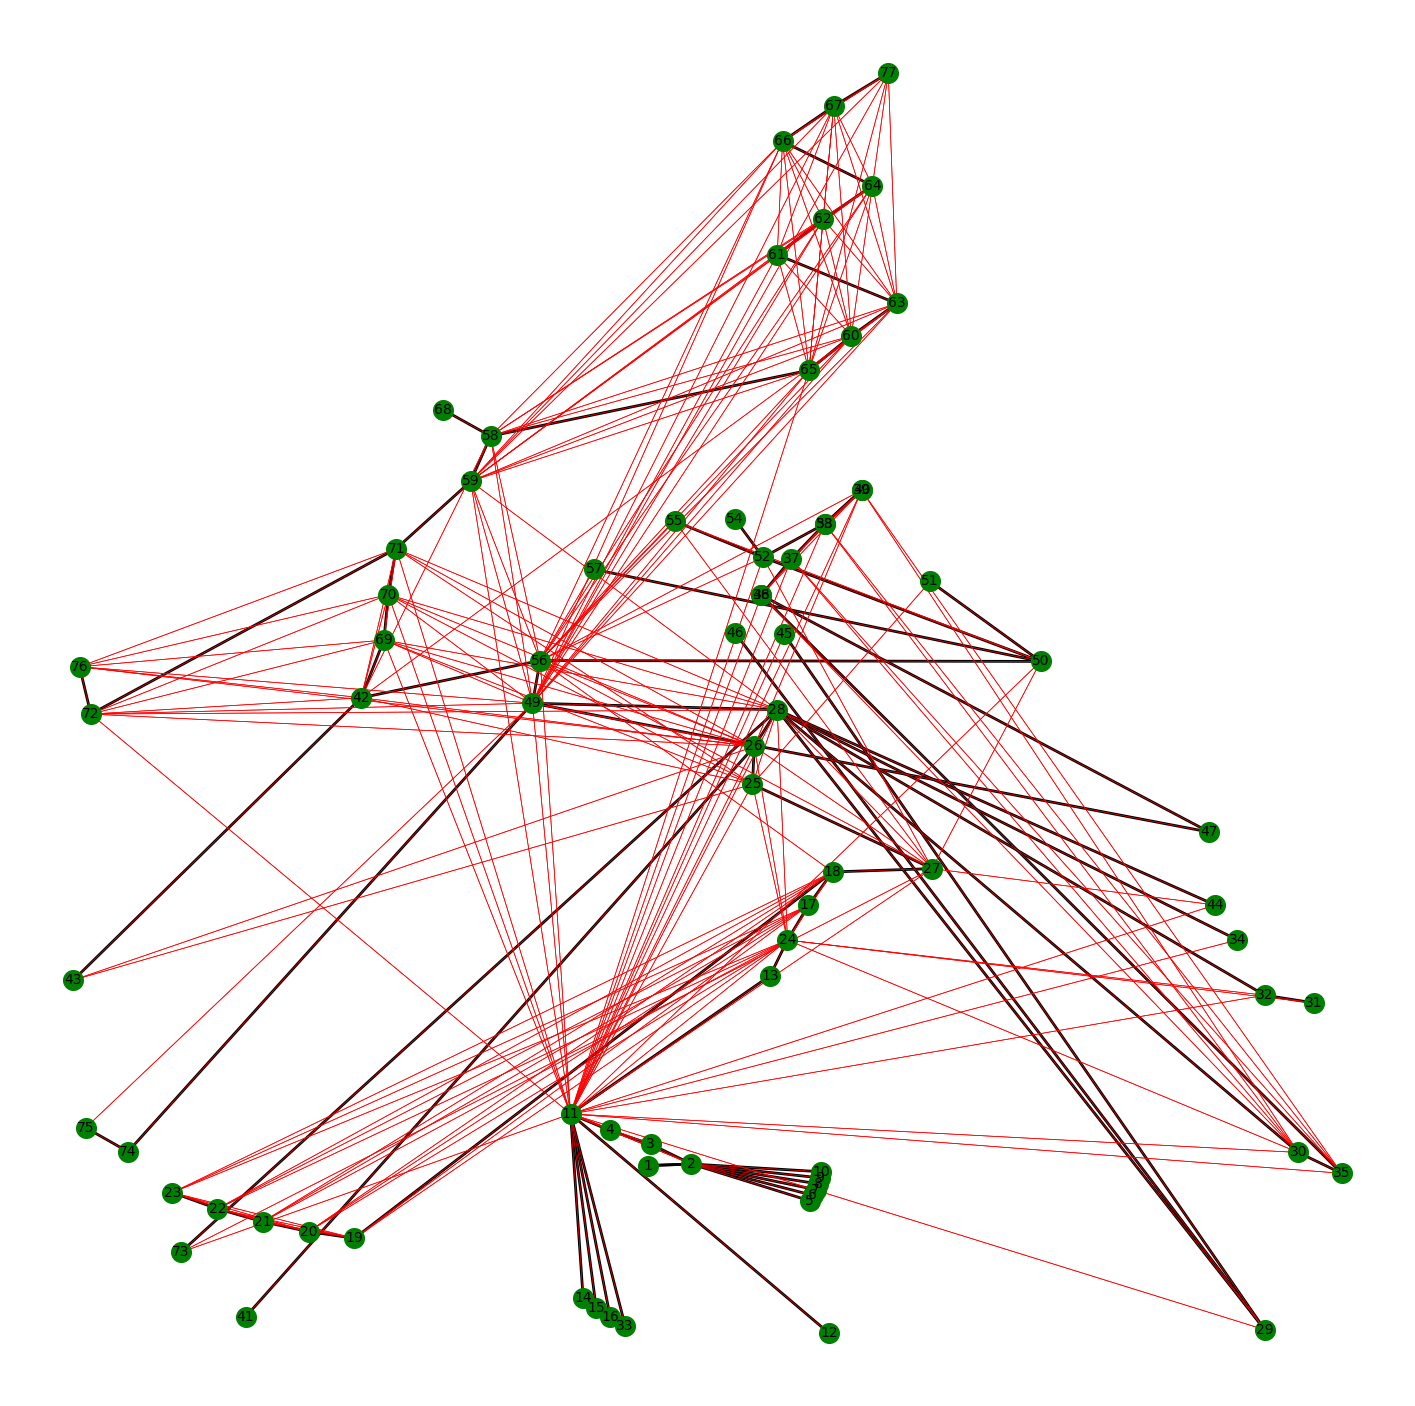

In [ ]:
show_graph_with_invalid_edges('example.dot','radial',tree = 'DFS')

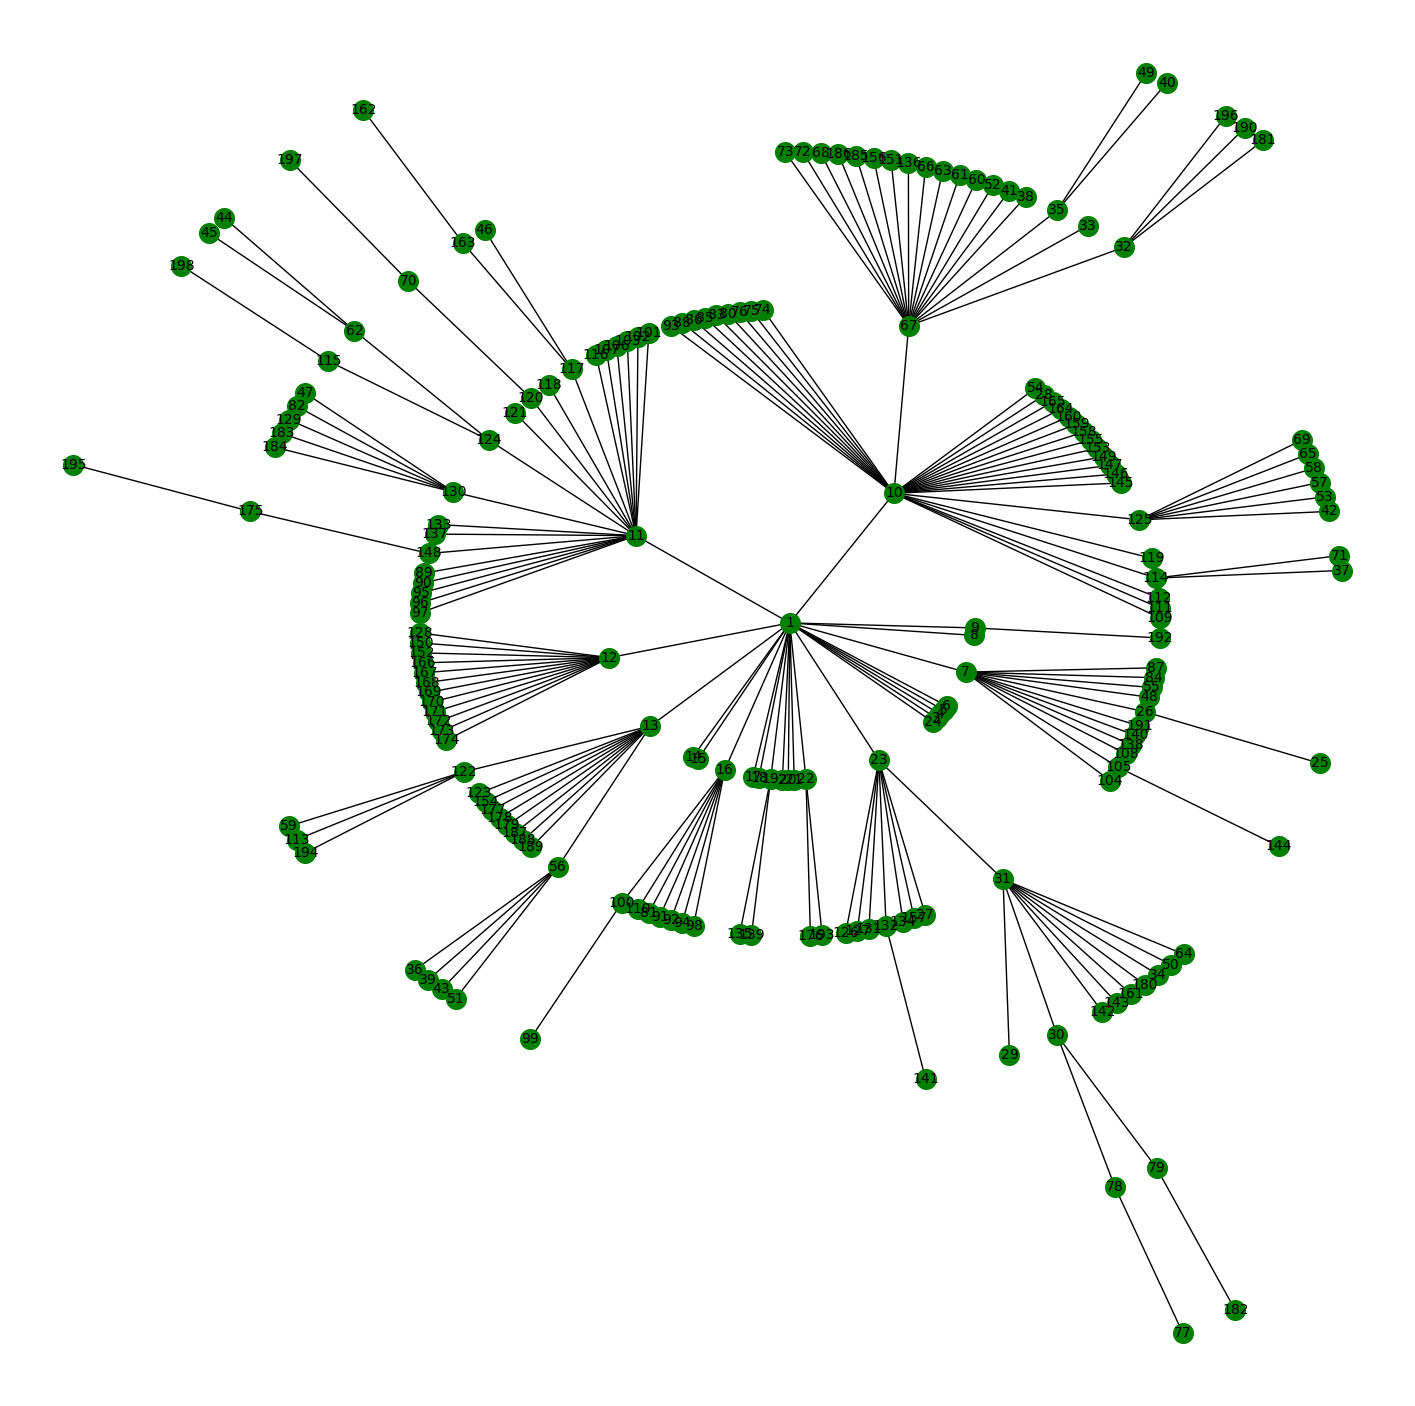

In [ ]:
show_graph('Datasets/JazzNetwork.dot','radial',tree = 'BFS')

Comments

This visualization is not great for the Les Misérables network, given that the central node is node 1, and this node only has one incident edge. One way to fix this, is by ordering the nodes in a way that the node in the center is the one with the highest degree.
When it comes to the Jazz network, the BFS representation looks considerably good.

In [ ]:
#write_ordered_dic('Datasets/LesMiserables.dot','ordered_LesMiserables.dot')
#show_graph('ordered_LesMiserables.dot','radial')

### Compare the quality of the visualizations for the BFS and DFS

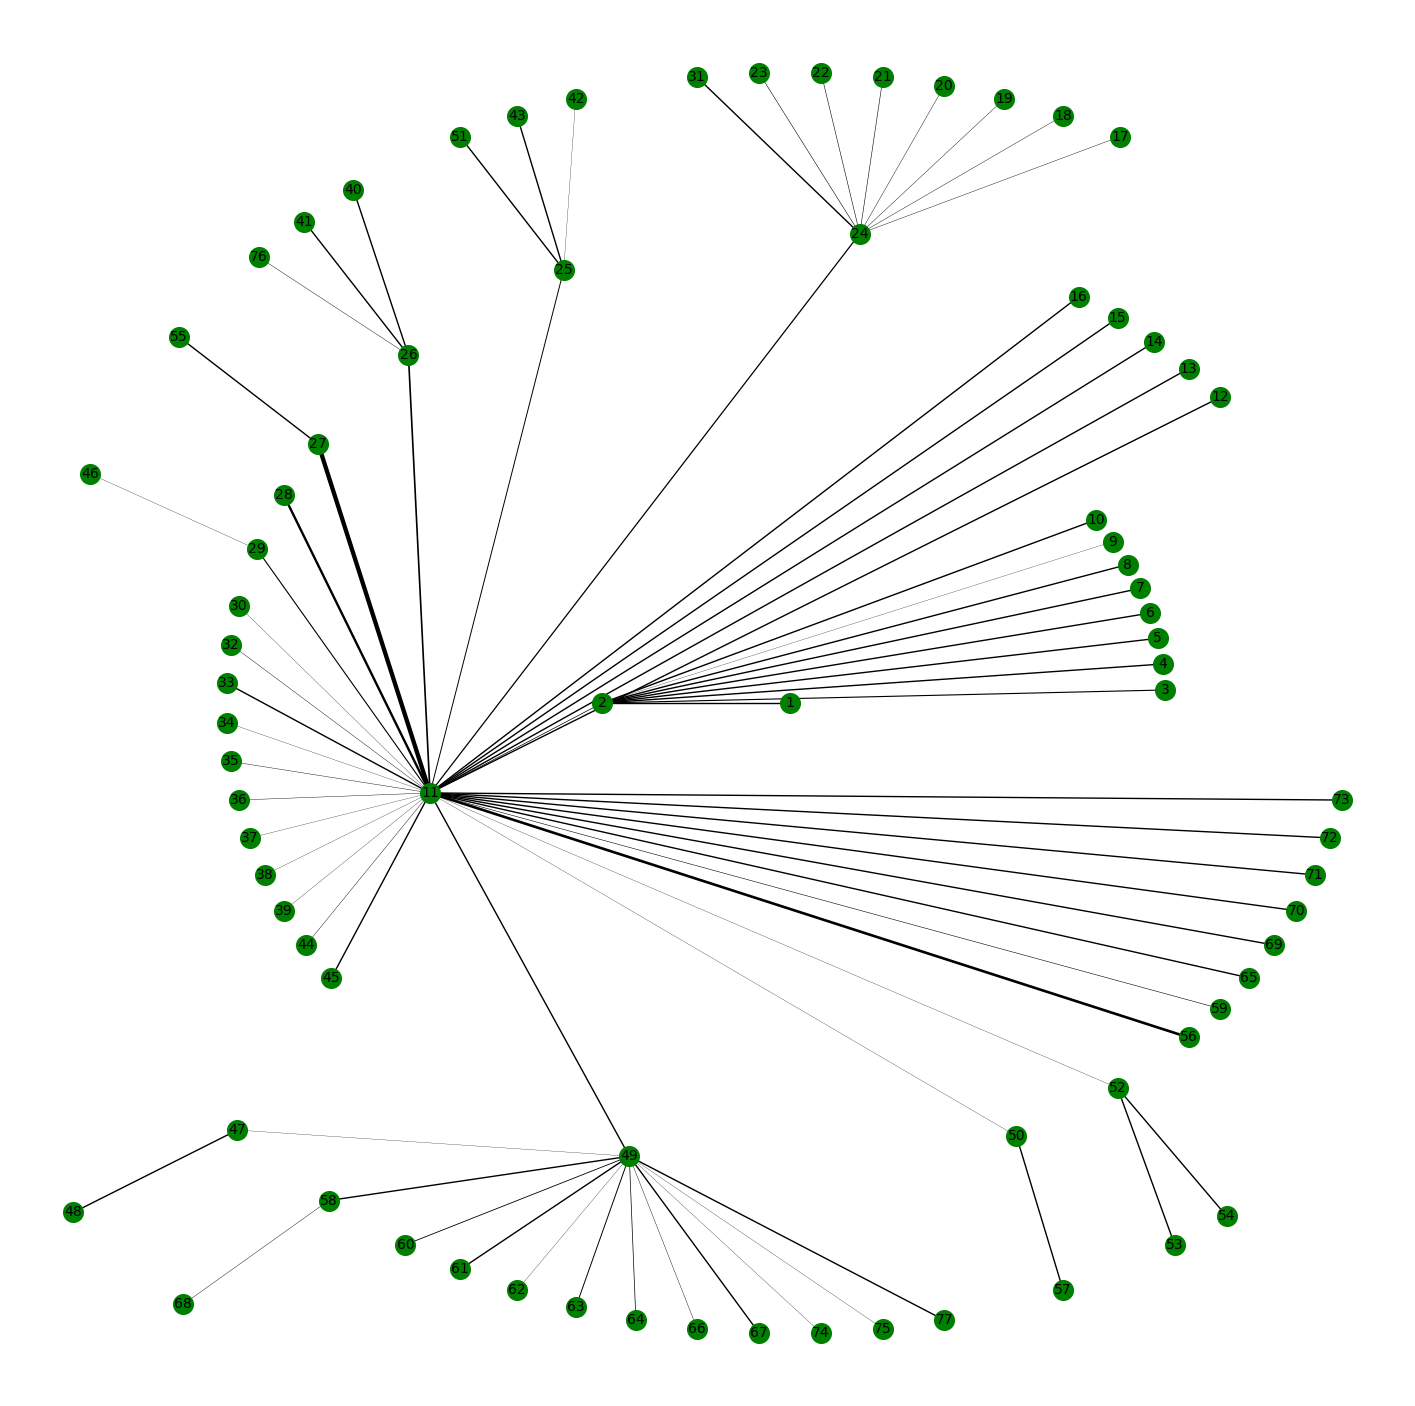

In [ ]:
show_graph('Datasets/LesMiserables.dot','radial',tree = 'BFS')

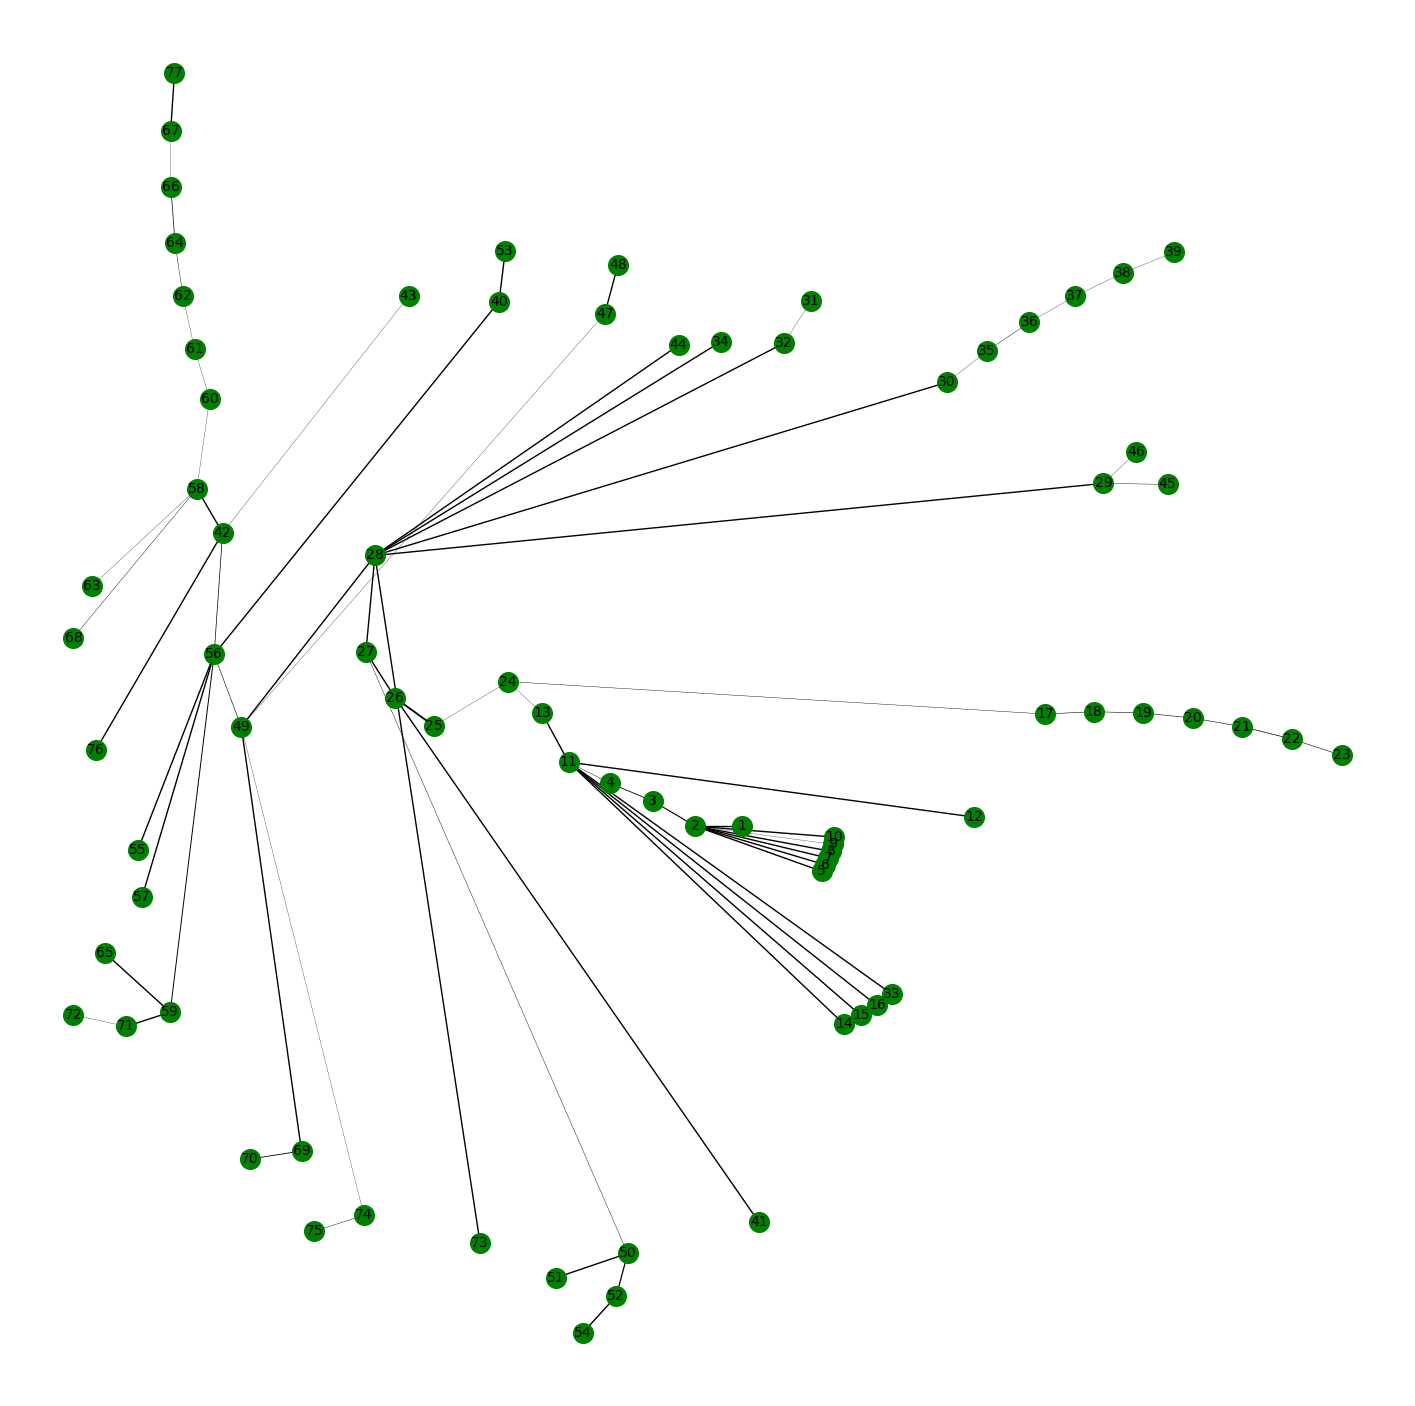

In [ ]:
show_graph('Datasets/LesMiserables.dot','radial',tree = 'DFS')

convergence signal!!! 280


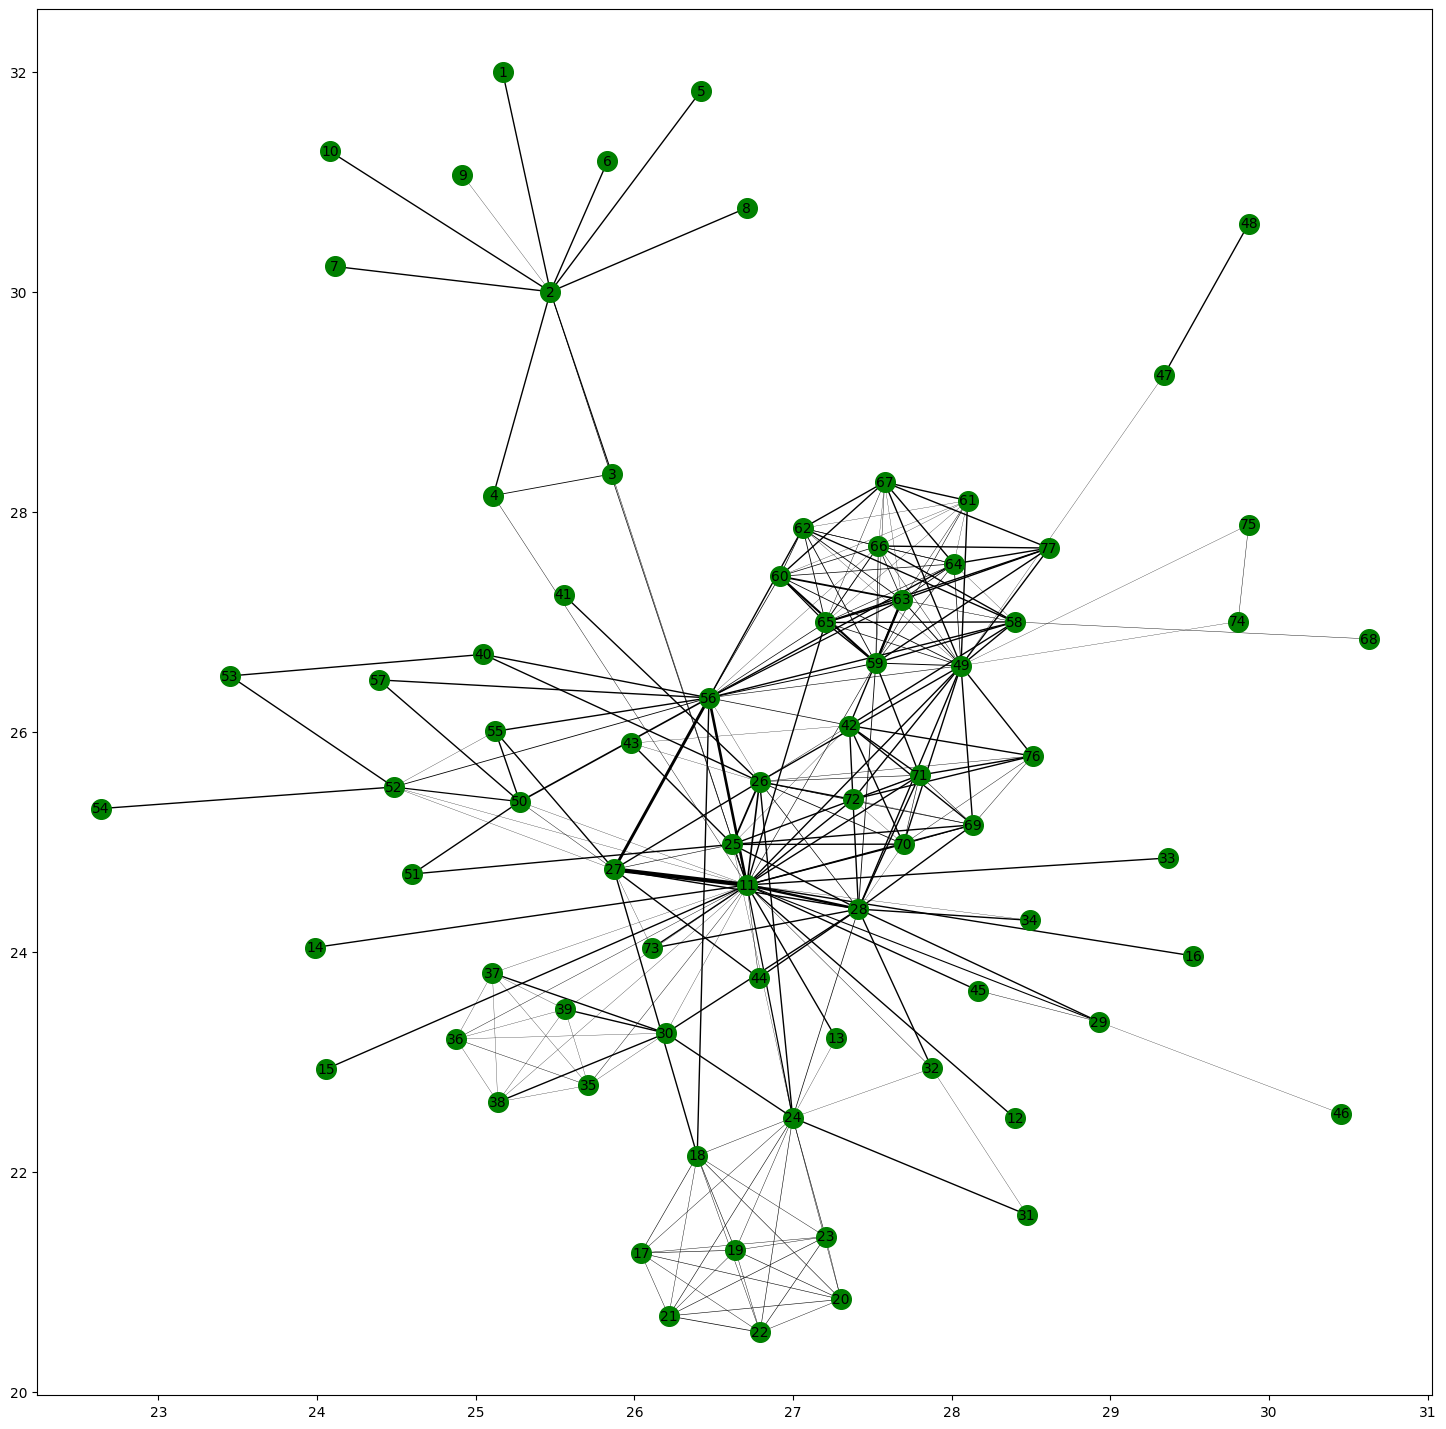

In [ ]:
def working_spring_embedder_hugo(file, max_ites=1000, plot='No', c_spring=2, c_rep=1, l=1, step=0.04,convergence_threshold=0.0005): 
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}

    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u.get_name()]

            for v in nodes:
                if u.get_name() != v.get_name():
                    pv = node_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2 + (pu[1]-pv[1])**2)
                    if dist == 0:
                        dist = 1

                    # Spring
                    if (u.get_name(), v.get_name()) in edge_list or (v.get_name(), u.get_name()) in edge_list:
                        constant = c_spring*math.log(dist)/l
                        force_x += (pv[0]-pu[0])*constant/dist
                        force_y += (pv[1]-pu[1])*constant/dist
                    # Repulsion
                    else:
                        constant = c_rep/dist**2
                        force_x += (pu[0]-pv[0])*constant/dist
                        force_y += (pu[1]-pv[1])*constant/dist
            changes.append(math.sqrt((force_x*step)**2 + (force_y*step)**2))
            new_x = pu[0] + force_x*step
            new_y = pu[1] + force_y*step
            node_positions[u.get_name()] = (new_x,new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)
        
        
        if average_movement < convergence_threshold:
            print("convergence signal!!!", ite) 
            break
        
        ite += 1
        step = step*0.99

    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
        

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.savefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()
        return None


    return node_positions, l_changes


l_f_v = working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000, plot='Yes',c_spring=6)

In [ ]:
#Example usage
num_nodes = 10
nodes = [i for i in range(0,10)]
edges = [(1, 2), (2, 3), (0, 4), (1, 5), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4), (4, 8), (5, 9)]

def create_pydot_graph(nodes, edges, filename):
    graph = pydot.Dot(graph_type='digraph')

    # Add nodes to the graph
    for node in nodes:
        graph.add_node(pydot.Node(node))

    # Add edges to the graph
    for edge in edges:
        src, dest = edge
        graph.add_edge(pydot.Edge(src, dest))

    # Write the graph to a .dot file
    graph.write(filename)

create_pydot_graph(nodes, edges,'test_force.dot')
#show_graph("test_force.dot", layout="layered_ish", tree="BFS")

The BFS representation looks much better than the DFS representation. This happens because the BFS results in a tree that 

# TRASH

In [ ]:
def BFS_tree(file,plot = 'No'):
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    #edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes = set()
    #node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    tree = {node.get_name(): [] for node in nodes}
    min_y = 0

    for node in nodes:
        done_nodes.add(str(node.get_name()))
        childs = node_childs[str(node.get_name())]
        parent_x = node_positions[str(node.get_name())][0]
        parent_y = node_positions[str(node.get_name())][1]
        step = 3

        if len(node_childs[str(node.get_name())]) == 1 and str(node_childs[str(node.get_name())][0]) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            child_x = parent_x + step
            child_y = parent_y
            node_positions[str(node_childs[str(node.get_name())][0])] = (child_x, child_y)
            done_nodes.add(str(node_childs[str(node.get_name())][0]))
            tree[node.get_name()].append(str(node_childs[str(node.get_name())][0]))
            
        elif len(node_childs[str(node.get_name())]) >1:# and node_childs[str(node.get_name())] not in done_nodes:
            new_childs = len([child for child in node_childs[str(node.get_name())] if child not in done_nodes])
            max_y = (new_childs-1)*3
            
            done_childs = []
            for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
                done_childs.append(child)
                child_x = parent_x + step
                child_y = parent_y + max_y
                
                node_positions[child] = (child_x, child_y)
                done_nodes.add(str(child))
                max_y -= 6
                tree[node.get_name()].append(str(child))

            if len(done_childs)>0:
                min_y = node_positions[done_childs[-1]][1]

    # if plot != 'No':
    #     plt.figure(figsize=(18, 18))

    #     reached_dests = set()
    #     for edge in edges:
    #         if node_positions[str(edge.get_source())][0] != node_positions[str(edge.get_destination())][0] and str(edge.get_destination()) not in reached_dests:
    #             start_node = edge.get_source()
    #             end_node = edge.get_destination()
    #             start_pos = node_positions[start_node]
    #             end_pos = node_positions[end_node]

    #             position = str(str(edge.get_attributes())).rfind(':')
    #             if int(position) != -1:
    #                 w = int(str(edge.get_attributes())[position+3:-2])
    #                 if w != 1:
    #                     w = w/10
    #         plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
    #         reached_dests.add(str(edge.get_destination()))
    #     for node, pos in node_positions.items():
    #         plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
    #         plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
    #     plt.axis('off')
    #     plt.gca().set_facecolor('w')
    #     plt.savefig('BFS_tree_plot.png')
    #     plt.show()
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return node_positions,final_tree

#write_ordered_dic('Datasets/LesMiserables.dot')
#tree = BFS_tree('example.dot',plot='YEs')[1]
#tree = BFS_tree('Datasets/LesMiserables.dot')

#tree = BFS_tree('example.dot')
#show_graph('Datasets/LesMiserables.dot','BFS_tree',(18,18))
# #print("Edges: ",n, '\n',"Nodes: ",m, '\n',"Total: ",total,)
# #f_childs(nodes,edges)[1]['17']

In [ ]:
#OLD
def hugo_radial(file,ordesection = False):
    if ordesection != False:
        new_file = write_ordesection_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    #radius = 3
    root = list(tree.keys())[0]
    layers = f_layers(file)
    angle = 0
    start_angle=0
    for subtree in tree:
        #root = subtree
        for node in tree[subtree]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)
            #print(layer)
            radius = 3*layer

            parent_x = node_positions[get_key(tree,node)][0]
            parent_y = node_positions[get_key(tree,node)][1]
            
            descendants = count_descendants(tree, node)
            if layer <= 1: 
                if descendants >0:
                    increment = 2*math.pi*(descendants+1)/count_descendants(tree, root)
                else:
                    increment = 2*math.pi/count_descendants(tree, root)

            if layer > 1:             
                section = 2*math.pi*(1+count_descendants(tree, subtree))/76#count_descendants(tree, subtree)
                if parent_y >0:
                    start_angle = math.acos(parent_x/(3*(layer-1)))-section/2
                elif parent_y <0:
                    start_angle = math.pi+math.acos(parent_x/(3*(layer-1)))-section/2
                
                if descendants >0:
                    increment = 2*math.pi*(count_descendants(tree, node)+1)/76
                else:
                    increment = 2*math.pi*(count_descendants(tree, node)+1)/76
            
            #if layer == 2:
                #print('node: ', node,'section: ',math.degrees(section),'starting angle: ',math.degrees(start_angle),'increment: ',math.degrees(increment))
                #print('node: ', node,'increment: ',math.degrees(increment))
            #if root in ['11','24']:
            #done list
                #increment done
                #section done
                
            angle+= start_angle+increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
   
    return node_positions


#write_ordesection_dic('Datasets/LesMiserables.dot')
#hugo_radial('example.dot')

In [ ]:
#import matplotlib.pyplot as plt
def f_plot(file):
    '''old function for plotting radial layout'''
    ans = radial(file)
    x_coords = [coord[0] for coord in ans.values()]
    y_coords = [coord[1] for coord in ans.values()]

    plt.figure(figsize=(15, 15))
    plt.scatter(x_coords, y_coords, color='red')

    # Add labels for each point
    for point, coord in ans.items():
        plt.text(coord[0], coord[1], f' {point}', fontsize=12, ha='right')
    
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of Points')
    plt.grid(True)
    plt.show()

#f_plot('example.dot')

In [ ]:
#OLD
def radial23(file,ordered = False):
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    #radius = 3
    root = list(tree.keys())[0]
    layers = f_layers(file)
    angle = 0
    starting_angle=0
    for subtree in tree:
        root = subtree
        for node in tree[root]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)
            #print(layer)
            radius = 3*layer

            parent_x = node_positions[node][0]
            parent_y = node_positions[node][1]
            
            descendants = count_descendants(tree, node)
            if descendants >0:
                childs = tree[node]
                increment = 2*math.pi*(descendants+1)/count_descendants(tree, root)
            else:
                increment = 2*math.pi/count_descendants(tree, root)
            #print(subtree,':',angle)
            if radius >3:
                acos = math.acos(parent_x/radius)
                asin = math.asin(parent_x/radius)
                if parent_y >0:
                    starting_angle = math.acos(parent_x/radius)
                elif parent_y <0:
                    starting_angle = math.pi+math.acos(parent_x/radius)
            
            
            if root in ['11','2']:
                angle+= increment/2-starting_angle
                child_x = math.cos(angle)*radius
                child_y = math.sin(angle)*radius
                angle+= increment/2
                node_positions[node]=(child_x,child_y)
   
    return node_positions


#write_ordered_dic('Datasets/LesMiserables.dot','example.dot')
#ans1 = radial('example.dot')

In [ ]:
def new_radial(file,ordered = False):
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    radius = 3
    root = list(tree.keys())[0]

    
    layers = f_layers(file)
    for layer in layers[1:]:
        angle = 0
        for node in layer:
            descendants = count_descendants(tree[node], node)
            if descendants >0:
                childs = tree[node]
                increment = 2*math.pi*(descendants+1)/count_descendants(tree, subtree)
            else:
                increment = 2*math.pi/count_descendants(tree, subtree)
                #print(node,':',angle)

            angle+= increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
        radius += 3

    # angle = 0
    # for subtree in tree:
    #     for node in subtree:
    #         descendants = count_descendants(tree, node)
    #         if descendants >0:
    #             childs = tree[node]
    #             increment = 2*math.pi*(descendants+1)/count_descendants(tree, subtree)
    #         else:
    #             increment = 2*math.pi/count_descendants(tree, subtree)
    #             #print(node,':',angle)

    #         angle+= increment/2
    #         child_x = math.cos(angle)*radius
    #         child_y = math.sin(angle)*radius
    #         angle+= increment/2
    #         node_positions[node]=(child_x,child_y)
    #     radius += 3
    return node_positions


#ans = new_radial('example.dot')

In [ ]:
def tree(file):#,starting_point):
    graph = get_data(file)
    nodes_ish = graph[0]
    nodes = sorted([int(node.get_name()) for node in nodes_ish])
    #print(nodes)
    edges = graph[1]
    #root = starting_point
    links = f_edges(file)[1]

    tree = {node: [] for node in nodes}
    done_nodes = []
    for child in childs:
        tree[root].append(child)
        done_nodes.add(child)
    #print('root', root,'childs: ', childs)
    # print('done nodes: ',done_nodes)        
    # print('#######')
    while len(done_nodes)!=len(nodes):
        for child1 in childs:
            root = child1
            print('root', root,'childs: ', childs)
            #if root not in done_nodes:
            done_nodes.add(root)
            new_childs = [child2 for child2 in links[root] if child2 not in done_nodes]
            #print('root', root,'childs: ', new_childs)
            if len(new_childs)==1 and new_childs[0] not in done_nodes:
                tree[child1].append(new_childs[0])
                done_nodes.add(new_childs[0])
            
            elif len(new_childs)>1:# and new_childs[0] not in done_nodes:
                for child2 in new_childs:
                    if child2 not in done_nodes:
                        tree[child1].append(child2)
                        done_nodes.add(child2)
        
            # print('done nodes: ',done_nodes)        
            # print('#################')
        yet_to_do_nodes = [node for node in nodes if node not in done_nodes]
        #yet_to_do_nodes = [set(graph[2])-done_nodes]
        root = sorted(list(yet_to_do_nodes))[0]
        done_nodes.add(root)
        childs = links[root]
        #print('root', root,'childs: ', childs)
        #print('#######')
    return tree

#ans = tree('Datasets/LesMiserables.dot')#,'1')
#print(ans)



### Trash-ish for radial layout

In [ ]:
#new_file = write_ordered_dic('Datasets/LesMiserables.dot')

def radial1(file,ordered = False):
    # total = 0
    # n=0
    # graph = get_data(file)
    # nodes = graph[0]
    # edges = graph[1]
    # node_positions = {node.get_name(): (0, 0) for node in nodes}
    # done_nodes= []
    # node_child_count = f_childs(file)[0]
    # node_childs = f_childs(file)[1]
    if ordered != False:
        new_file = write_ordered_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    tree = BFS_tree(file)[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    radius = 3
    angle = 360/3
    for node in tree:
        childs = tree[str(node)]
        #print('node: ', node, 'childs: ', childs)
        parent_x = node_positions[node][0]
        parent_x = node_positions[node][1]
        increment = 360/len(childs)
        num_childs = len(childs)
        angle = 0
        for child in childs:
            angle += increment
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius

            node_positions[child]=(child_x,child_y)
            
        radius += 2
    return node_positions

#ans = radial('example.dot')

# General Code

In [ ]:
#print(edges.get_values())
#for node in nodes:
 #   print("Node name:", node.get_name())
  #  print("Node label:", node.get_label())
   # print("Node attributes:", node.get_attributes())
    #print("Node shape:", node.get_shape())
    #print("Node style:", node.get_style())
    #print("Node position:", node.get_pos())
    
    
#for edge in edges:
 #   print("Source:", edge.get_source())
  #  print("Destination:", edge.get_destination())
    #print("Edge attributes:", edge.get_attributes())
    #position = str(str(edge.get_attributes())).rfind(':')
    #w = str(edge.get_attributes())[position+3:-2]
    #print(w)
    #print("Edge style:", edge.get_style())
    #print("Edge label:", edge.get_label())
    #print("Edge color:", edge.get_color())

# TRASH